Step 1: Import libraries

In [1]:
import sys, gdal, re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Step 2: Define the function to convert RGB rasters to arrays (RGBraster2array)

This function reads in a NEON AOP geotiff file and returns a numpy array, and an header that contains associated metadata with spatial information. 

Parameters:
    
    RGB_geotif -- full or relative path and name of reflectance hdf5 file
    
Returns:
    
    array: numpy array of geotif values
    
    metadata: dictionary containing the following metadata (all strings):
            -array_rows
            -array_cols
            -bands
            -driver
            -projection
            -geotransform
            -pixelWidth
            -pixelHeight
            -extent
            -noDataValue
            -scaleFactor
            
Example of execution:
    
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif)

In [2]:
def RGBraster2array(RGB_geotif):
    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

Step 3: Define the RGB image to read

In [3]:
RGB_geotif = './2017_SERC_2_368000_4306000_image.tif'

Step 4: Run the function (RGBraster2array) to extract the array and metadata from RGB image.

In [4]:
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

Step 5: Display the information stored in header

In [5]:
for key in sorted(SERC_RGBcam_metadata.keys()):
  print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


Step 6: Define function to plot the array data

plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array

Parameters:
    
    band_array: flightline array of reflectance values, created from h5refl2array function
    
    refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
    
    colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
    
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
        
       
Returns: 

    plots array of single band or RGB if given a 3-band 

Example:

plot_band_array(SERC_RGBcam_array, SERC_RGBcam_metadata['extent'],
(1,255), title='SERC RGB Camera Tile', cbar='off')

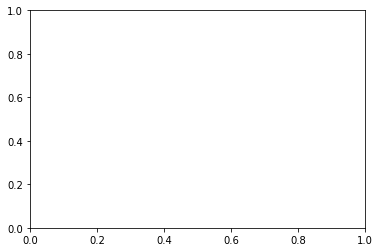

In [6]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

Step 7: Plot the array data from the RGB image defined earlier

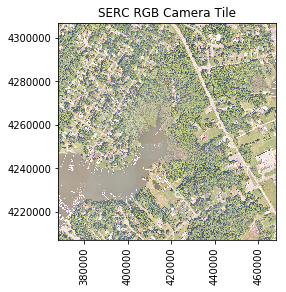

In [7]:
plot_band_array(SERC_RGBcam_array, SERC_RGBcam_metadata['extent'],(1,255), title='SERC RGB Camera Tile', cbar='off') 

Step 8: Plot the histogram of the bands (individually and then combined)

Text(0,0.5,'Frequency')

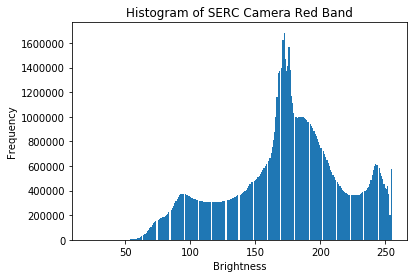

In [8]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),256);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

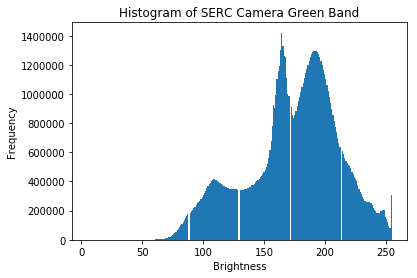

In [9]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),256);
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

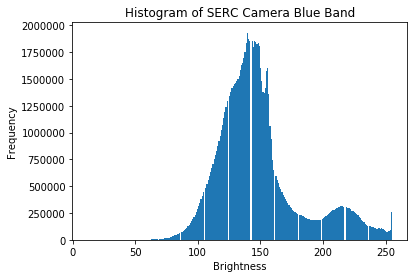

In [10]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),256);
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

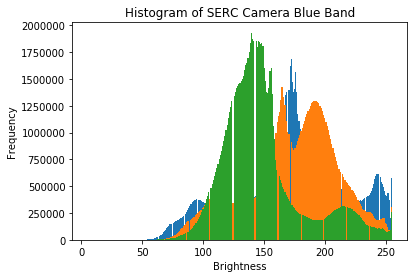

In [11]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),256);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),256);
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),256);
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Step 9: Determine the minimum and maximum reflectance for each band

In [12]:
for i in range(0,3):
    min = np.amin(SERC_RGBcam_array[:,:,i])
    max = np.amax(SERC_RGBcam_array[:,:,i])
    if i == 0:
        print('-The minimum reflectance for the Red band is '+str(min)+' and its maximum reflectance is '+str(max)+'.')
    elif i == 1:
        print('-The minimum reflectance for the Green band is '+str(min)+' and its maximum reflectance is '+str(max)+'.')
    elif i == 2:
        print('-The minimum reflectance for the Blue band is '+str(min)+' and its maximum reflectance is '+str(max)+'.')

-The minimum reflectance for the Red band is 21 and its maximum reflectance is 255.
-The minimum reflectance for the Green band is 5 and its maximum reflectance is 255.
-The minimum reflectance for the Blue band is 12 and its maximum reflectance is 255.


Step 10: Determine the UTM zone of the image

In [13]:
try:
    UTMzone = re.search('UTM(.+?)\"', str(SERC_RGBcam_metadata['projection'])).group(1)
except AttributeError:
    UTMzone = 'UTM Zone not found'

print('The image is in UTM'+ UTMzone + '.')

The image is in UTM zone 18N.


Step 11: Plot each band individually

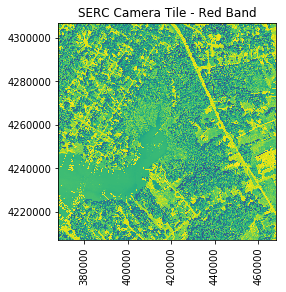

In [14]:
plot_band_array(SERC_RGBcam_array[:,:,0], SERC_RGBcam_metadata['extent'],(1,255), title='SERC Camera Tile - Red Band', cbar='off')

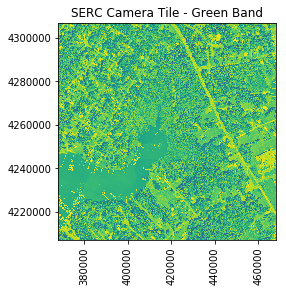

In [15]:
plot_band_array(SERC_RGBcam_array[:,:,1], SERC_RGBcam_metadata['extent'],(1,255), title='SERC Camera Tile - Green Band', cbar='off')

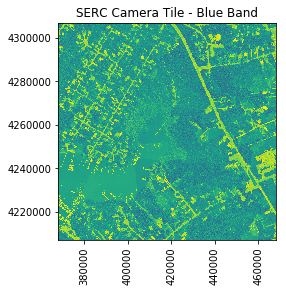

In [16]:
plot_band_array(SERC_RGBcam_array[:,:,2], SERC_RGBcam_metadata['extent'],(1,255), title='SERC Camera Tile - Blue Band', cbar='off') 

THE END.
07/04/2018